# Introduction
This notebook will be used to share my analysis as to whether an SBA loan should be approved or denied based on the provided SBA loan data. 

In [1]:
# Import packages used for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

C:\Users\RIKUNCH\AppData\Local\Temp\ipykernel_12976\3767933995.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Load the SBA loan data and make a copy for exploration
df = pd.read_excel('./SBAnational.xlsx')

df_copy = df.copy()
# Drop null values from specified columns
df_copy.dropna(subset=['Name', 'City', 'State', 'BankState', 'NewExist','RevLineCr', 'LowDoc', 'DisbursementDate', 'MIS_Status'], inplace=True)
df_copy.isnull().sum()
# Remove '$', commas, and extra spaces from records in columns with dollar values that should be floats
df_copy[['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']] = \
df_copy[['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']].applymap(lambda x: x.strip().replace('$', '').replace(',', ''))
df_copy['ApprovalFY'].apply(type).value_counts()
def clean_str(x):
    if isinstance(x, str):
        return x.replace('A', '')
    return x


df_copy['ApprovalFY'] = df_copy['ApprovalFY'].apply(clean_str).astype('int64')
df_copy = df_copy.astype({'Zip': 'str', 'NewExist': 'int64', 'UrbanRural': 'str', 'DisbursementGross': 'float', 'BalanceGross': 'float',
                          'ChgOffPrinGr': 'float', 'GrAppv': 'float', 'SBA_Appv': 'float'})

# Check to see dtypes so far
df_copy.dtypes
df_copy = df_copy[(df_copy['NewExist'] == 1) | (df_copy['NewExist'] == 2)]

# Create NewBusiness field where 0 = Existing business and 1 = New business; based on NewExist field
df_copy.loc[(df_copy['NewExist'] == 1), 'NewBusiness'] = 0
df_copy.loc[(df_copy['NewExist'] == 2), 'NewBusiness'] = 1

C:\Users\RIKUNCH\AppData\Local\Temp\ipykernel_12976\3877701360.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_copy[['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']].applymap(lambda x: x.strip().replace('$', '').replace(',', ''))


In [3]:
# Remove records where RevLineCr != 'Y' or 'N' and LowDoc != 'Y' or 'N'
df_copy = df_copy[(df_copy['RevLineCr'] == 'Y') | (df_copy['RevLineCr'] == 'N')]
df_copy = df_copy[(df_copy['LowDoc'] == 'Y') | (df_copy['LowDoc'] == 'N')]

# RevLineCr and LowDoc: 0 = No, 1 = Yes
df_copy['RevLineCr'] = np.where(df_copy['RevLineCr'] == 'N', 0, 1)
df_copy['LowDoc'] = np.where(df_copy['LowDoc'] == 'N', 0, 1)

# Check that it worked
print(df_copy['RevLineCr'].unique())
print(df_copy['LowDoc'].unique())
df_copy['Default'] = np.where(df_copy['MIS_Status'] == 'P I F', 0, 1)
df_copy['Default'].value_counts()
df_copy[['ApprovalDate', 'DisbursementDate']] = df_copy[['ApprovalDate', 'DisbursementDate']].apply(pd.to_datetime)

[0 1]
[1 0]


One metric I thought of that would be interesting to see is the number of days it took from the approval of the loan to the actual disbursement of the funds. My hypothesis is that the timing at which the funds were received could have a negative relationship with a business's ability to repay a loan, whereas the longer it took to receive funds, the more difficult it would be to pay off the loan. In my experience as a Credit Analyst, there were a number of businesses that needed loan funding urgently to help the business stay afloat. I'm sure this would vary by industry however.

In [4]:
# Create DaysToDisbursement column which calculates the number of days passed between DisbursementDate and ApprovalDate
df_copy['DaysToDisbursement'] = df_copy['DisbursementDate'] - df_copy['ApprovalDate']

# Change DaysToDisbursement from a timedelta64 dtype to an int64 dtype
# Converts series to str, removes all characters after the space before 'd' in days for each record, then changes the dtype to int
df_copy['DaysToDisbursement'] = df_copy['DaysToDisbursement'].astype('str').apply(lambda x: x[:x.index('d') - 1]).astype('int64')

In [5]:
# Create DisbursementFY field for time selection criteria later
df_copy['DisbursementFY'] = df_copy['DisbursementDate'].map(lambda x: x.year)

Another metric I was interested in exploring is whether or not the bank servicing the loan was in the same state that the business was located. My assumption is that it would be more difficult to service a loan for a business in another state and that this could have a negative impact on a business's ability to repay the loan.

In [6]:
# Create StateSame flag field which identifies where the business State is the same as the BankState
df_copy['StateSame'] = np.where(df_copy['State'] == df_copy['BankState'], 1, 0)

The next field I decided to create relates to the amount of the loan the SBA guaranteed. This is a unique feature SBA loans have where the SBA will 'guaranty' a percentage of the loan in the event of a loss. For example if a business took out a 500,000 loan and the SBA guaranteed 50%, if the business was unable to repay 200,000 of the loan the SBA would cover 100,000 of that loss. This makes these loans very attractive to small businesses because it mitigates their risk, but it also increases the risk for the SBA. This is why an analysis like this is important! These loans are typically guaranteed on a percentage basis rather than a specified dollar amount, so I create a field to represent this rather than the guaranteed amount provided in the original dataset.

In [7]:
# Create SBA_AppvPct field since the guaranteed amount is based on a percentage of the gross loan amount rather than dollar amount in most situations
df_copy['SBA_AppvPct'] = df_copy['SBA_Appv'] / df_copy['GrAppv']

I wanted to look at whether the loan amount disbursed was equal to the full amount approved, so I added that feature as well.

In [8]:
# Create AppvDisbursed flag field signifying if the loan amount disbursed was equal to the full amount approved
df_copy['AppvDisbursed'] = np.where(df_copy['DisbursementGross'] == df_copy['GrAppv'], 1, 0)

In [9]:
df_copy.drop(columns=['LoanNr_ChkDgt', 'Name', 'City', 'Zip', 'Bank', 'NAICS', 'ApprovalDate', 'NewExist', 'FranchiseCode',
                      'ChgOffDate', 'DisbursementDate', 'BalanceGross', 'ChgOffPrinGr', 'SBA_Appv', 'MIS_Status'], inplace=True)

In [10]:
# Verify all null values are removed from data
df_copy.isnull().sum()

State                 0
BankState             0
ApprovalFY            0
Term                  0
NoEmp                 0
CreateJob             0
RetainedJob           0
UrbanRural            0
RevLineCr             0
LowDoc                0
DisbursementGross     0
GrAppv                0
NewBusiness           0
Default               0
DaysToDisbursement    0
DisbursementFY        0
StateSame             0
SBA_AppvPct           0
AppvDisbursed         0
dtype: int64

In [11]:
# Select only records with a disbursement year through 2010
df_copy = df_copy[df_copy['DisbursementFY'] <= 2010]

# Check how many records remain
df_copy.shape

(591750, 19)

### Data Analysis
Let's take a break now that we have done some data cleaning and formatting to see what we're dealing with now.

In [12]:
df_copy.describe(include=['object', 'float', 'int'])

State BankState     ApprovalFY           Term         NoEmp  \
count   591750    591750  591750.000000  591750.000000  591750.00000   
unique      51        54            NaN            NaN           NaN   
top         CA        NC            NaN            NaN           NaN   
freq     78609     62238            NaN            NaN           NaN   
mean       NaN       NaN    2000.339621     105.716345      11.96668   
std        NaN       NaN       6.488099      75.823644      76.41385   
min        NaN       NaN    1969.000000       0.000000       0.00000   
25%        NaN       NaN    1995.000000      60.000000       2.00000   
50%        NaN       NaN    2002.000000      84.000000       4.00000   
75%        NaN       NaN    2006.000000     120.000000      11.00000   
max        NaN       NaN    2011.000000     527.000000    9999.00000   

            CreateJob    RetainedJob UrbanRural      RevLineCr         LowDoc  \
count   591750.000000  591750.000000     591750  591750.000000  591750.000000   
unique            NaN            NaN          3            NaN            NaN   
top               NaN            NaN          1            NaN            NaN   
freq              NaN            NaN     277605            NaN            NaN   
mean        11.349256      13.416554        NaN       0.320779       0.096456   
std        289.353076     289.430572        NaN       0.466776       0.295216   
min          0.000000       0.000000        NaN       0.000000       0.000000   
25%          0.000000       0.000000        NaN       0.000000       0.000000   
50%          0.000000       0.000000        NaN       0.000000       0.000000   
75%          1.000000       3.000000        NaN       1.000000       0.000000   
max       8800.000000    8800.000000        NaN       1.000000       1.000000   

        DisbursementGross        GrAppv    NewBusiness        Default  \
count        5.917500e+05  5.917500e+05  591750.000000  591750.000000   
unique                NaN           NaN            NaN            NaN   
top                   NaN           NaN            NaN            NaN   
freq                  NaN           NaN            NaN            NaN   
mean         1.805293e+05  1.680840e+05       0.269867       0.185012   
std          2.491460e+05  2.417411e+05       0.443891       0.388308   
min          4.000000e+03  1.000000e+03       0.000000       0.000000   
25%          4.000000e+04  3.000000e+04       0.000000       0.000000   
50%          9.100000e+04  7.500000e+04       0.000000       0.000000   
75%          2.150000e+05  2.000000e+05       1.000000       0.000000   
max          1.144632e+07  5.000000e+06       1.000000       1.000000   

        DaysToDisbursement  DisbursementFY      StateSame    SBA_AppvPct  \
count        591750.000000   591750.000000  591750.000000  591750.000000   
unique                 NaN             NaN            NaN            NaN   
top                    NaN             NaN            NaN            NaN   
freq                   NaN             NaN            NaN            NaN   
mean            120.915451     2000.424357       0.525440       0.701091   
std             186.857421        6.396352       0.499353       0.183455   
min          -12393.000000     1948.000000       0.000000       0.050000   
25%              31.000000     1995.000000       0.000000       0.500000   
50%              63.000000     2002.000000       1.000000       0.750000   
75%             127.000000     2006.000000       1.000000       0.850000   
max            8813.000000     2010.000000       1.000000       1.000000   

        AppvDisbursed  
count   591750.000000  
unique            NaN  
top               NaN  
freq              NaN  
mean         0.709191  
std          0.454136  
min          0.000000  
25%          0.000000  
50%          1.000000  
75%          1.000000  
max          1.000000

This shows some interesting information for the analysis, including:
* The average loan term is ~94 months with a standard deviation of ~69 months, suggesting the loan terms are pretty spread out; Max loan term of 527 months could suggest some outliers in the data
* The average number of employees is about 9.8 with 75% of of businesses having 9 or less employees, suggesting NoEmp is very left skewed; Similar situations for created and retained jobs
* The mean for flag fields essentially shows a percentage, so roughly 42% of loans in the sample are revolving lines of credit and about 6% of loans were a part of the Low Doc program
* Average gross loan disbursement was ~166,000 with 75% of loans being less than 188,000, suggesting left skewness again
* About 77.8% of loans in the sample were paid in full
* Only 3% of businesses were franchised; About 26% of loan applicants were considered new businesses.
* The average days to loan disbursement was 109; The min was -3,614, suggesting at least one error in the data (since that's ~301 years)
* Approximately 45.4% of loans were serviced by banks in the same state as the applying business
* The average percentage of SBA loan guaranteed amount was 65.4%
* About 11.2% of the loans backed by real estate per my assumptions
* About 73.4% of the loans in the sample were active at some point during the Great Recession

After reviewing these details, there are a few more things I want to add to aid in this analysis. One of these things is to create a flag that signifies if the disbursed amount was greater than what was actually approved. I think this would have interesting implications because the disbursement of extra funds could suggest that the business was at greater risk of default. This could be correlated to revolving lines of credit where the business continually draws and pays down a balance however.

In [13]:
# Create flag to signify if a larger amount was disbursed than what the Bank had approved
# Likely RevLineCr?
df_copy['DisbursedGreaterAppv'] = np.where(df_copy['DisbursementGross'] > df_copy['GrAppv'], 1, 0)

I also wanted to remove records with a negative DaysToDisbursement under the assumption that loan funds would not be disbursed until they were approved.

In [14]:
# Remove records with loans disbursed prior to being approved
df_copy = df_copy[df_copy['DaysToDisbursement'] >= 0]

# Check how many records are left
df_copy.shape

(591180, 20)

In [15]:
df_copy.describe(include=['object', 'float', 'int'])

State BankState     ApprovalFY           Term          NoEmp  \
count   591180    591180  591180.000000  591180.000000  591180.000000   
unique      51        54            NaN            NaN            NaN   
top         CA        NC            NaN            NaN            NaN   
freq     78538     62218            NaN            NaN            NaN   
mean       NaN       NaN    2000.337645     105.717885      11.967545   
std        NaN       NaN       6.486215      75.825324      76.447976   
min        NaN       NaN    1969.000000       0.000000       0.000000   
25%        NaN       NaN    1995.000000      60.000000       2.000000   
50%        NaN       NaN    2002.000000      84.000000       4.000000   
75%        NaN       NaN    2006.000000     120.000000      11.000000   
max        NaN       NaN    2011.000000     527.000000    9999.000000   

            CreateJob    RetainedJob UrbanRural      RevLineCr         LowDoc  \
count   591180.000000  591180.000000     591180  591180.000000  591180.000000   
unique            NaN            NaN          3            NaN            NaN   
top               NaN            NaN          1            NaN            NaN   
freq              NaN            NaN     277384            NaN            NaN   
mean        11.358835      13.425199        NaN       0.320914       0.096363   
std        289.492325     289.569719        NaN       0.466828       0.295089   
min          0.000000       0.000000        NaN       0.000000       0.000000   
25%          0.000000       0.000000        NaN       0.000000       0.000000   
50%          0.000000       0.000000        NaN       0.000000       0.000000   
75%          1.000000       3.000000        NaN       1.000000       0.000000   
max       8800.000000    8800.000000        NaN       1.000000       1.000000   

        DisbursementGross        GrAppv    NewBusiness        Default  \
count        5.911800e+05  5.911800e+05  591180.000000  591180.000000   
unique                NaN           NaN            NaN            NaN   
top                   NaN           NaN            NaN            NaN   
freq                  NaN           NaN            NaN            NaN   
mean         1.805185e+05  1.680721e+05       0.269859       0.185086   
std          2.491170e+05  2.417126e+05       0.443887       0.388367   
min          4.000000e+03  1.000000e+03       0.000000       0.000000   
25%          4.000000e+04  3.000000e+04       0.000000       0.000000   
50%          9.100000e+04  7.500000e+04       0.000000       0.000000   
75%          2.150000e+05  2.000000e+05       1.000000       0.000000   
max          1.144632e+07  5.000000e+06       1.000000       1.000000   

        DaysToDisbursement  DisbursementFY      StateSame    SBA_AppvPct  \
count        591180.000000   591180.000000  591180.000000  591180.000000   
unique                 NaN             NaN            NaN            NaN   
top                    NaN             NaN            NaN            NaN   
freq                   NaN             NaN            NaN            NaN   
mean            121.081770     2000.422670       0.525373       0.701072   
std             186.102744        6.394023       0.499356       0.183477   
min               0.000000     1969.000000       0.000000       0.050000   
25%              31.000000     1995.000000       0.000000       0.500000   
50%              63.000000     2002.000000       1.000000       0.750000   
75%             127.000000     2006.000000       1.000000       0.850000   
max            8813.000000     2010.000000       1.000000       1.000000   

        AppvDisbursed  DisbursedGreaterAppv  
count   591180.000000         591180.000000  
unique            NaN                   NaN  
top               NaN                   NaN  
freq              NaN                   NaN  
mean         0.709087              0.237165  
std          0.454184              0.425344  
min          0.000000              0.000000  
2

### Data Visualization
Although there are likely some potential outliers that could be explored, I want to start looking at the data from a new perspective. Before we go too far however, let's take a look at a correlation matrix to see the relationships among the features.

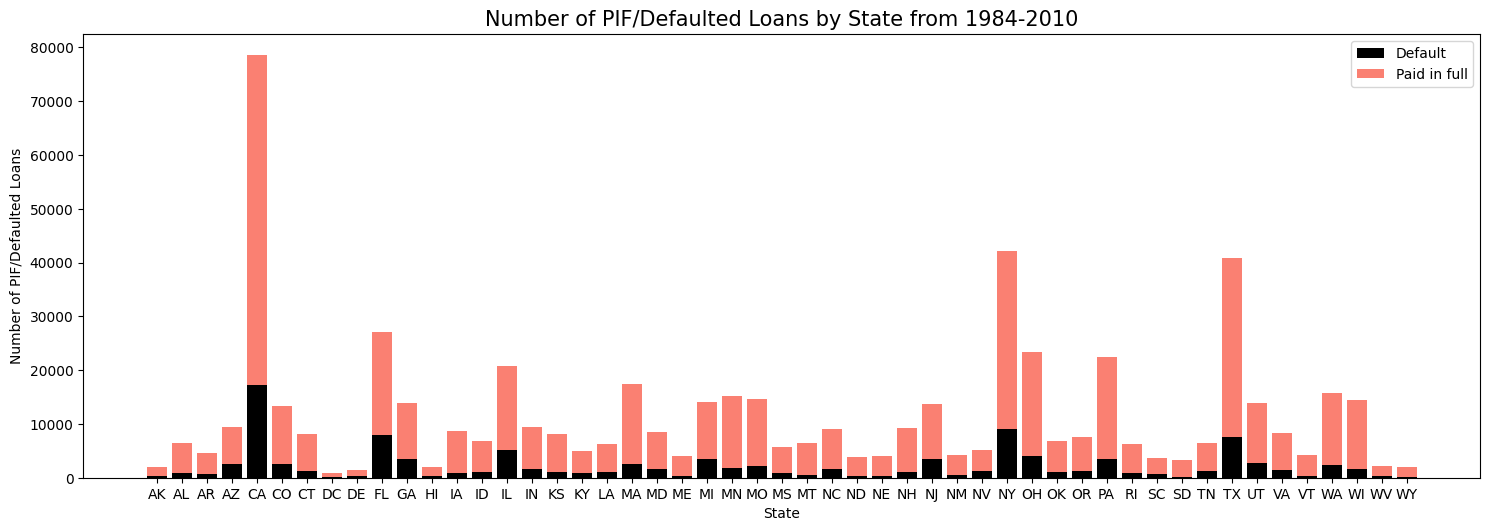

In [16]:
# Paid in full and defaulted loans
fig3 = plt.figure(figsize=(15, 10))

ax2a = plt.subplot(2, 1, 2)

# Function for creating stacked bar charts grouped by desired column
# df = original data frame, col = x-axis grouping, stack_col = column to show stacked values
# Essentially acts as a stacked histogram when stack_col is a flag variable
def stacked_setup(df, col, axes, stack_col='Default'):
    data = df.groupby([col, stack_col])[col].count().unstack(stack_col)
    data.fillna(0)

    axes.bar(data.index, data[1], label='Default',color='black')
    axes.bar(data.index, data[0], bottom=data[1], label='Paid in full',color='salmon')



# Number of Paid in full and defaulted loans by State
stacked_setup(df=df_copy, col='State', axes=ax2a)

ax2a.set_title('Number of PIF/Defaulted Loans by State from 1984-2010', fontsize=15)
ax2a.set_xlabel('State')
ax2a.set_ylabel('Number of PIF/Defaulted Loans')
ax2a.legend()

plt.tight_layout()
plt.show()

In [17]:
# Check Default percentage by State
def_state = df_copy.groupby(['State', 'Default'])['State'].count().unstack('Default')
def_state['Def_Percent'] = def_state[1]/(def_state[1] + def_state[0])
def_state

Default      0      1  Def_Percent
State                             
AK        1725    230     0.117647
AL        5472    969     0.150442
AR        3899    700     0.152207
AZ        6775   2589     0.276484
CA       61267  17271     0.219906
CO       10703   2596     0.195203
CT        6864   1179     0.146587
DC         772    174     0.183932
DE        1184    263     0.181755
FL       19202   7974     0.293421
GA       10543   3433     0.245635
HI        1655    293     0.150411
IA        7861    844     0.096956
ID        5862   1005     0.146352
IL       15608   5118     0.246936
IN        7740   1693     0.179476
KS        7064    995     0.123464
KY        4088    959     0.190014
LA        5177   1005     0.162569
MA       15030   2478     0.141535
MD        6901   1583     0.186587
ME        3675    404     0.099044
MI       10522   3486     0.248858
MN       13297   1829     0.120918
MO       12398   2160     0.148372
MS        4908    796     0.139551
MT        5952    419     0.065767
NC        7500   1552     0.171454
ND        3599    294     0.075520
NE        3589    385     0.096880
NH        8130   1042     0.113607
NJ       10237   3498     0.254678
NM        3697    453     0.109157
NV        3876   1310     0.252603
NY       33095   9049     0.214716
OH       19283   4076     0.174494
OK        5873   1012     0.146986
OR        6254   1230     0.164351
PA       19008   3522     0.156325
RI        5404    818     0.131469
SC        2868    707     0.197762
SD        3077    221     0.067010
TN        5276   1165     0.180873
TX       33161   7605     0.186553
UT       11067   2775     0.200477
VA        6805   1482     0.178834
VT        3878    315     0.075125
WA       13347   2311     0.147592
WI       12803   1696     0.116974
WV        1900    325     0.146067
WY        1890    131     0.064819

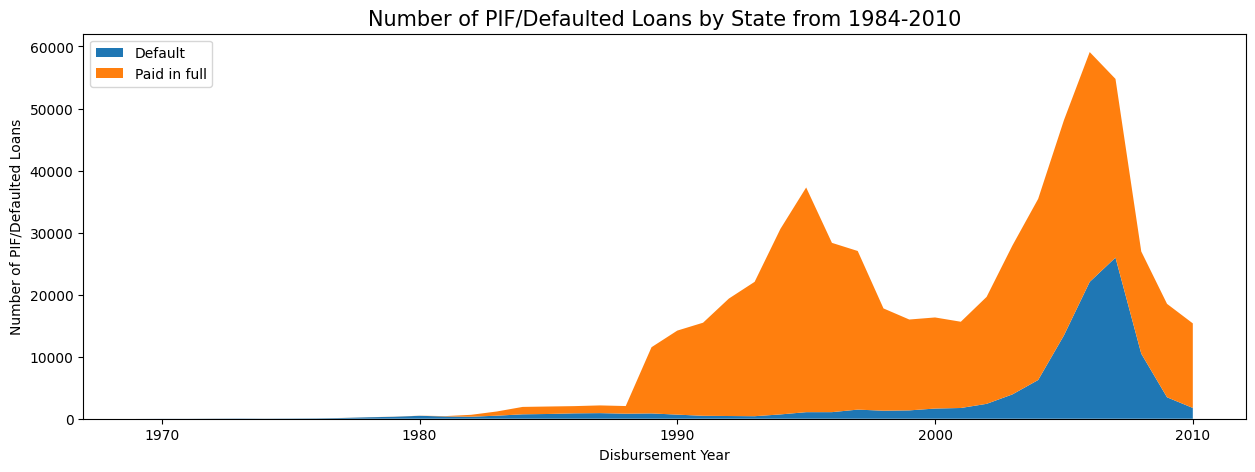

In [18]:
# Paid in full and Defaulted loans by DisbursementFY
# Decided to use a stacked area chart here since it's time series data
fig4, ax4 = plt.subplots(figsize=(15, 5))

stack_data = df_copy.groupby(['DisbursementFY', 'Default'])['DisbursementFY'].count().unstack('Default')
x = stack_data.index
y = [stack_data[1], stack_data[0]]

ax4.stackplot(x, y, labels=['Default', 'Paid in full'])
ax4.set_title('Number of PIF/Defaulted Loans by State from 1984-2010', fontsize=15)
ax4.set_xlabel('Disbursement Year')
ax4.set_ylabel('Number of PIF/Defaulted Loans')
ax4.legend(loc='upper left')

plt.show()

There is a clear increase in loan volume leading up to the peak of the Great Recession, with a subsequent drop in loan volume immediately following that time. Looking at the graph, it appears the default rate of loans increased during that time as well.

Text(0, 0.5, 'Loan Amount ($)')

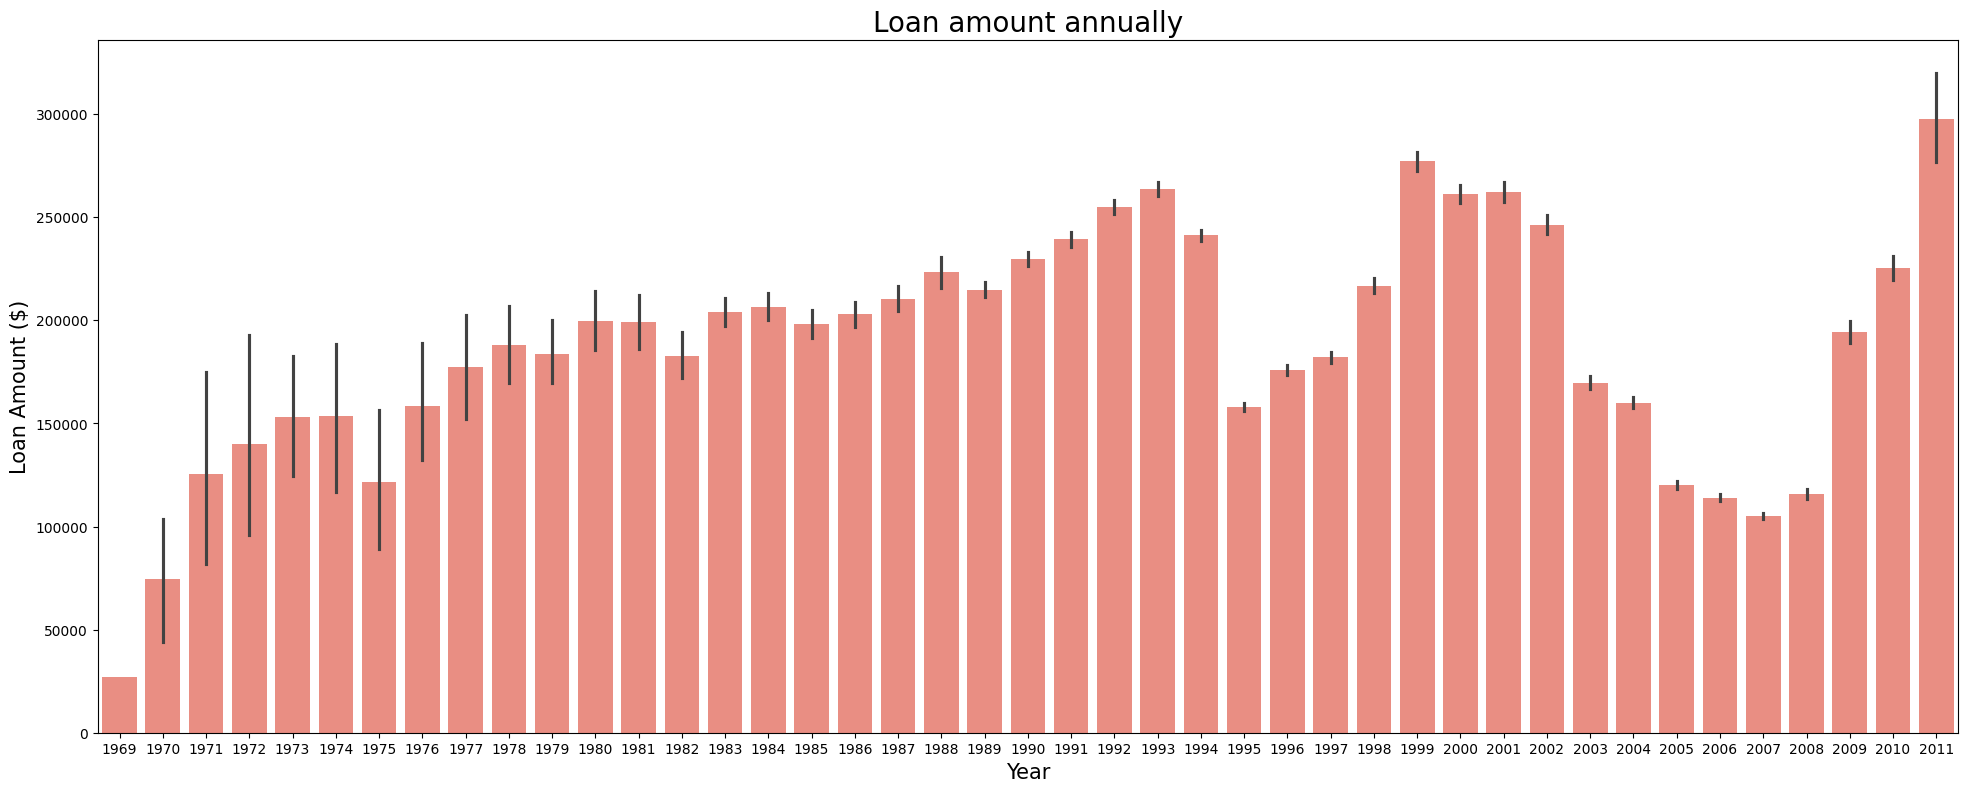

In [19]:
f, ax = plt.subplots(figsize=(24,9))
sns.barplot(x="ApprovalFY", y="DisbursementGross", color='Salmon', data=df_copy)
ax.set_title('Loan amount annually', fontsize=20)
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('Loan Amount ($)', fontsize=15)

C:\Users\RIKUNCH\AppData\Local\Temp\ipykernel_12976\3487690562.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=df['Term'], bins = 40,kde=False)


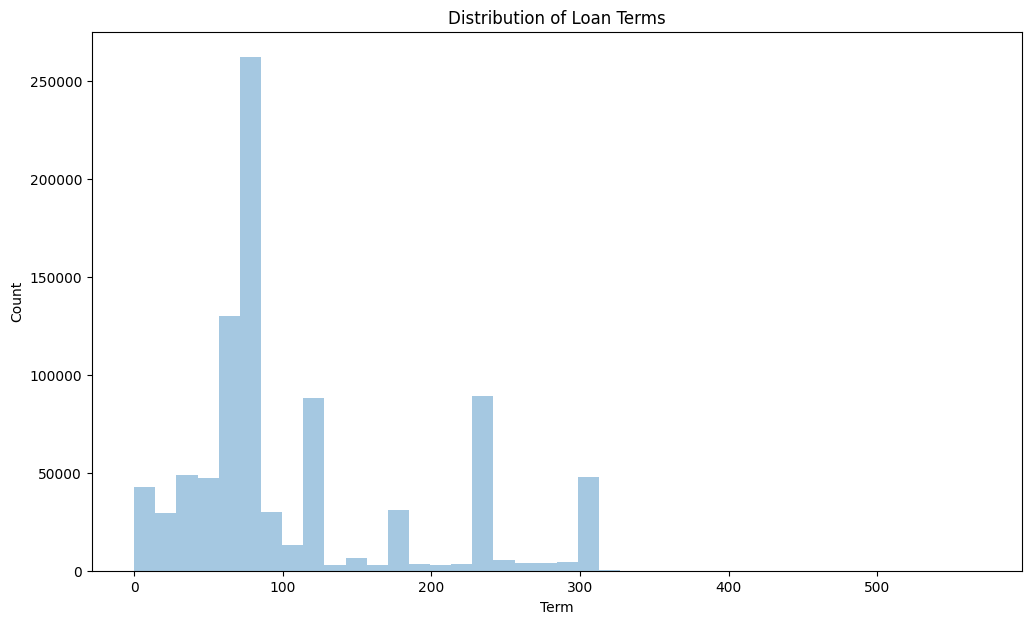

In [20]:
fig = plt.figure(figsize=(12,7))
sns.distplot(a=df['Term'], bins = 40,kde=False)
plt.title('Distribution of Loan Terms')
plt.ylabel('Count')
plt.show()

C:\Users\RIKUNCH\AppData\Local\Temp\ipykernel_12976\568353407.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=df_copy['ApprovalFY'],bins=40, kde=False)


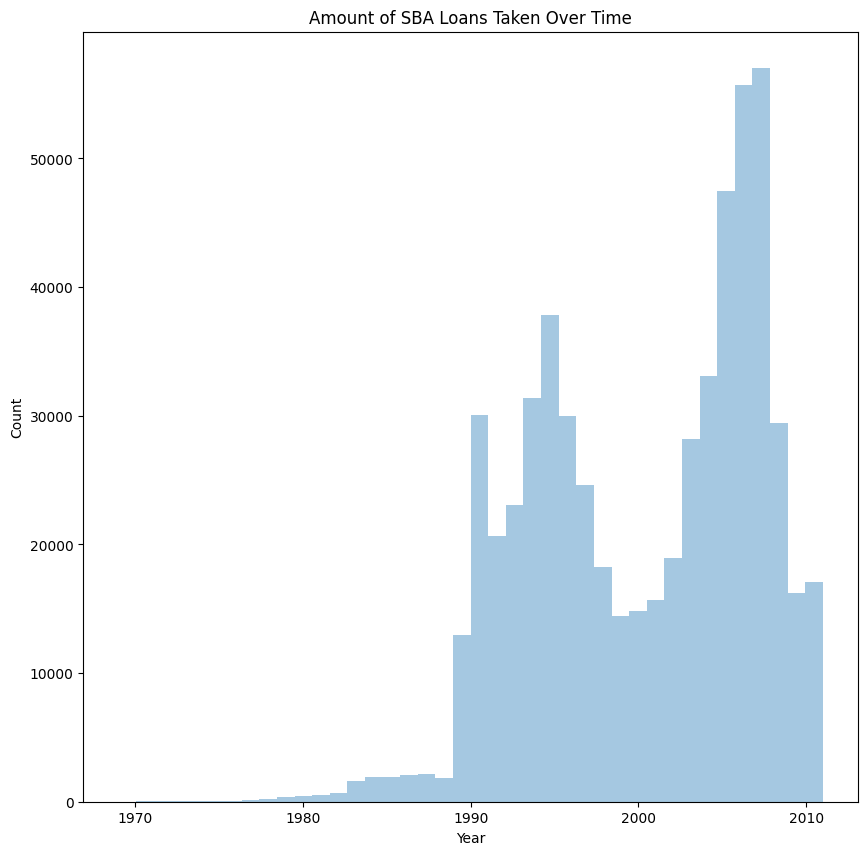

In [21]:
fig = plt.figure(figsize=(10,10))
sns.distplot(a=df_copy['ApprovalFY'],bins=40, kde=False)
plt.title('Amount of SBA Loans Taken Over Time')
plt.ylabel('Count')
plt.xlabel('Year')
plt.show()